In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import json

In [3]:
# Importing required functionalities

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
# Reading raw data, removing NaN values
path = './data/'

def remove_nans(data):
  # data: list of rows
    index = 0
    count = 0

    while index < len(data):
        flag = 0
        for item in data[index]:
            if type(item) is not str and np.isnan(item) == True:
                flag = 1
                break

        if flag == 1:
            del data[index]
            count += 1
        else:
            index += 1

    return count, data

with open(path + 'train_data.json', 'r+') as f:
    train_data = json.load(f)

with open(path + 'test_data.json', 'r+') as f:
    test_data = json.load(f)

train_nans, train_data = remove_nans(train_data)
test_nans, test_data = remove_nans(test_data)
raw_data = train_data + test_data

train = np.asarray(train_data)
test = np.asarray(test_data)
raw = np.asarray(raw_data)

print('Number of rows with NaNs in raw train: ' + str(train_nans))
print('Number of rows with NaNs in raw test: ' + str(test_nans))

Number of rows with NaNs in raw train: 9075
Number of rows with NaNs in raw test: 983


In [5]:
with open(path + 'head_to_col_id.json', 'r+') as f:
    mapping = json.load(f)

# Maps feature name to column ID

one_hot_flag = True

def get_categorizer(feature):
    global one_hot_flag
  
    if one_hot_flag:
        le = preprocessing.OneHotEncoder(sparse = False)
        le.fit(feature.reshape(-1, 1))
  
    else:
        le = preprocessing.LabelEncoder()
    le.fit(feature.reshape(-1, 1))
  
    return le

def categorize(model, data):
    global one_hot_flag
  
    if one_hot_flag:
        return model.transform(data.reshape(-1, 1)).astype(np.float32)
    else:
        return model.transform(np.ndarray.tolist(data)).reshape(-1, 1)

def get_scaler(feature):
    le = preprocessing.StandardScaler()
    le.fit(feature.reshape(-1, 1))
    return le

def scale(model, data):
    return model.transform(data.reshape(-1, 1)).reshape(-1, 1)

categorizers = []
scalers = []

def make_data():
    global train, test, raw, categorizers, scalers

    categorizable = ['neighbourhood_group', 'neighbourhood', 'room_type']
    scalable = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'price']

    train_cols = []
    test_cols = []

    # Saving categorizers and scalers

    for item in categorizable:
        categorizers.append(get_categorizer(raw[:, mapping[item]]))

    for item in scalable:
        scalers.append(get_scaler(train[:, mapping[item]]))

    # Building features

    for index, item in enumerate(categorizable):
        train_cols.append(categorize(categorizers[index], train[:, mapping[item]]))
        test_cols.append(categorize(categorizers[index], test[:, mapping[item]]))

    for index, item in enumerate(scalable):
        train_cols.append(scale(scalers[index], train[:, mapping[item]]))
        test_cols.append(scale(scalers[index], test[:, mapping[item]]))

    return train_cols, test_cols

In [6]:
# Defining the data matrix
train_cols, test_cols = make_data()
train_mat = np.hstack(train_cols)
X_train = train_mat[:, 0: -1]

In [7]:
# Reducing to two dimensions
method = 't-SNE'

print('Using One-Hot Encoding:', one_hot_flag)
print('Number of initial Features:', X_train.shape[1])

if method == 'PCA':
    pca = PCA(n_components = 2)
    transformed = pca.fit_transform(X_train)

else:
    transformed = TSNE(n_components = 2, method = 'barnes_hut', init = 'pca', learning_rate = 'auto', random_state = 2022).fit_transform(X_train)

print('Number of Features after dimensionality reduction:', transformed.shape[1])

Using One-Hot Encoding: True
Number of initial Features: 232
Number of Features after dimensionality reduction: 2


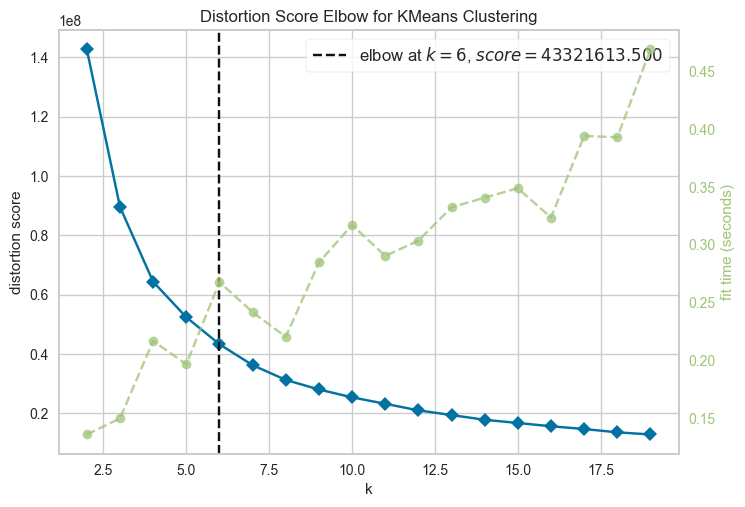

In [8]:
# Running K-means clustering

# Finding optimum K

model = KMeans(random_state = 2022)
visualizer = KElbowVisualizer(model, k = (2, 20))

visualizer.fit(transformed)
visualizer.show()
visualizer.finalize()

In [9]:
optim_K = visualizer.elbow_value_

Optimum K-value = 6



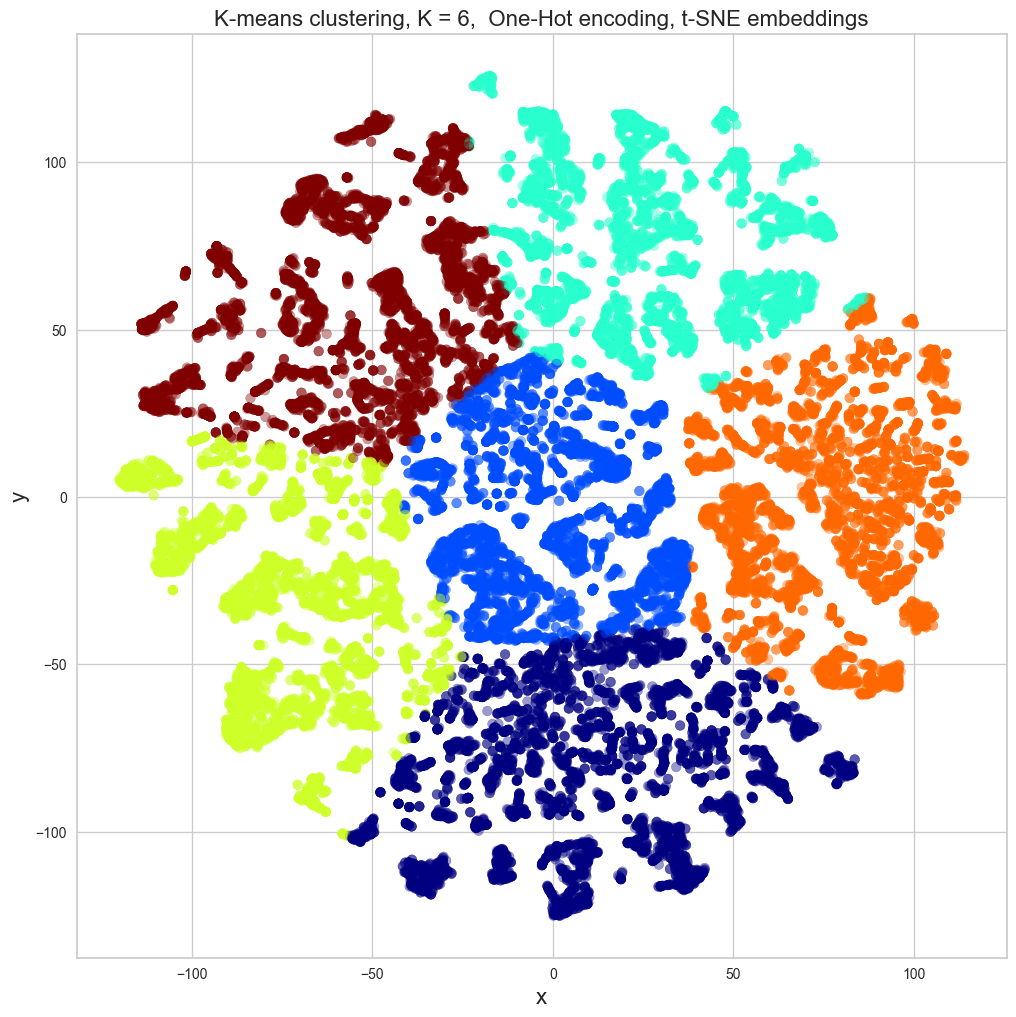

In [10]:
print('Optimum K-value =', optim_K)
print()

kmeans = KMeans(n_clusters = optim_K, random_state = 2022).fit(transformed)
labels = kmeans.predict(transformed)

plt.figure(figsize = (12, 12))
plt.subplot(111)
plt.scatter(transformed[:, 0], transformed[:, 1], c = labels, cmap = 'jet', alpha = 0.4)

title = 'K-means clustering, K = ' + str(optim_K) + ', '

if one_hot_flag:
    title += ' One-Hot encoding, '
else:
    title += 'Label encoding, '
    
title += method + ' embeddings'

plt.title(title, fontdict = {'fontsize': 16})

if method == 'PCA' and one_hot_flag:
    plt.xlim((-5, 12.5))
    plt.ylim((-4, 5))

elif method == 'PCA' and not one_hot_flag:
    plt.xlim((-110, 120))
    plt.ylim((-5, 15))
    
plt.xlabel('x', fontdict = {'fontsize': 16})
plt.ylabel('y', fontdict = {'fontsize': 16})

if one_hot_flag:
    figprefix = 'one_hot_'
else:
    figprefix = 'label_enc_'
    
save_it = True

if save_it:
    figprefix += method
    plt.savefig(figprefix + '_kmeans.pdf')

else:
    plt.show()

In [11]:
# Done